# Assignment 1: Co-stardom Network

Module: **COMP30850 Network Analysis (Spring 2021)**  
Name: **Rajit Banerjee**  
Student Number: **18202817**  
Data: `./data/`

Aim: To construct and characterise network representations of two movie-related datasets. Networks are created to model the co-starring relations between actors in these two datasets, i.e., the collaboration network of actors who appear together in the same movies.

1. [Network Construction](#Network-Construction)
2. [Network Characterisation](#Network-Characterisation)  
    2.1  [Network Size](#Network-Size)  
    2.2  [Edge Weight Distribution](#Edge-Weight-Distribution)  
    2.3  [Top Co-starring Relationships](#Top-Co-starring-Relationships)  
    2.4  [Density, Connectedness and Paths](#Density,-Connectedness-and-Paths)    
    2.5  [Clustering Coefficient](#Clustering-Coefficient)    
    2.6  [Degree Distribution](#Degree-Distribution)    
    2.7  [Degree Centrality](#Degree-Centrality)   
    2.8  [Betweenness Centrality](#Betweenness-Centrality)   
    2.9  [Closeness Centrality](#Closeness-Centrality)  
    2.10 [Eigenvector Centrality](#Eigenvector-Centrality)  
    2.11 [Summary of Network Characteristics](#Summary-of-Network-Characteristics)  
3. [Ego-centric Analysis](#Ego-centric-Analysis)
4. [Network Visualisation](#Network-Visualisation)

## Network Construction

First, let's load the two datasets and do some exploratory analysis.

In [1]:
import json

dataset1 = json.load(open('./data/18202817-dataset1.json', 'r'))
dataset2 = json.load(open('./data/18202817-dataset2.json', 'r'))

print(f'Dataset 1) type: {type(dataset1)}, size: {len(dataset1)}')
print(f'Dataset 2) type: {type(dataset2)}, size: {len(dataset2)}')

Dataset 1) type: <class 'list'>, size: 150
Dataset 2) type: <class 'list'>, size: 163


We find that each JSON dataset is a list of dictionaries, so let's see what keys are present in each dictionary.

In [2]:
def print_structure(d: dict, indent: int = 1) -> None:
    for key, value in d.items():
        print('____' * indent + str(key))
        if isinstance(value, dict):
            print_structure(value, indent+1)
        else:
            try:
                print_structure(value[0], indent+1)
            except:
                pass


print_structure(dataset1[0])

____id
____name
____born
____movies
________id
________title
________year
________kind


Each item in the dataset appears to contain an actor's ID, name, date of birth, and a list of movies (each with an ID, title, year of release and kind). We can now parse each JSON file into co-stardom networks, using NetworkX.

In [3]:
from itertools import combinations
import networkx as nx


def create_network(dataset: list) -> nx.Graph():

    # number of movies in which two actors co-star
    def count_common_movies(actor1: dict, actor2: dict) -> int:
        movies1 = set(m['id'] for m in actor1['movies'])
        movies2 = set(m['id'] for m in actor2['movies'])
        return len(movies1.intersection(movies2))

    g = nx.Graph()
    # iterate through every pair of actors
    for actor1, actor2 in combinations(dataset, r=2):
        common_movies = count_common_movies(actor1, actor2)

        # only add edges if actors co-star in at least one movie (thus preventing isolated nodes)
        if common_movies != 0:
            g.add_edge(actor1['name'], actor2['name'], weight=common_movies)
    return g


net1 = create_network(dataset1)
net2 = create_network(dataset2)

A **weighted, undirected network** is created for each dataset of actors. The nodes represent the names of the actors, and the edges between nodes symbolise a co-starring relationship between actors. The edges have a single attribute (weight), representing the number of movies which any two actors co-star in. The network is undirected because two actors co-starring in a movie implies a reciprocal relationship. Actors are only added to the network if they share an edge with at least one other actor, thereby preventing any **isolated** nodes.

## Network Characterisation

For each network (`net1`, `net2`), we can characterise its structure and apply centrality measures to identify important nodes.

### Network Size

The most basic characterisation we might perform would be simply to count the number of nodes and edges:

In [4]:
def size(net: nx.Graph) -> None:
    print(f'Number of nodes: {net.number_of_nodes()}')
    print(f'Number of edges: {net.number_of_edges()}')


size(net1)

Number of nodes: 147
Number of edges: 1322


In [5]:
size(net2)

Number of nodes: 159
Number of edges: 1602


We see that 147/150 actors have been added from dataset1, and 159/163 from dataset2. This means that the remaining nodes were isolated, and were not added to the network.

### Edge Weight Distribution 

Due to the weighted nature of the networks, we might want to look at the distribution of the edge weights.

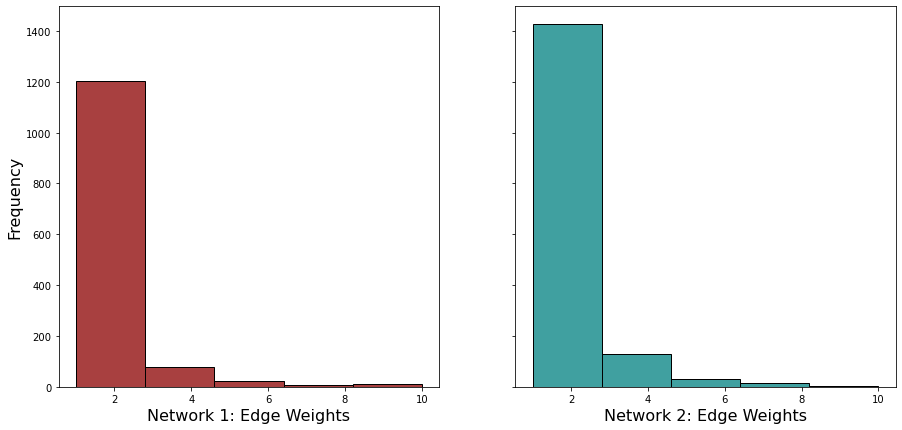

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


weights1 = [edge[-1]['weight'] for edge in net1.edges(data=True)]
weights2 = [edge[-1]['weight'] for edge in net2.edges(data=True)]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                               figsize=(15, 7), sharex=True, sharey=True)
sns.histplot(data=weights1, bins=5, color='darkred', ax=ax1)
ax1.set_xlabel('Network 1: Edge Weights', fontsize=16)
ax1.set_ylabel('Frequency', fontsize=16)

sns.histplot(data=weights2, bins=5, color='teal', ax=ax2)
ax2.set_xlabel('Network 2: Edge Weights', fontsize=16)
plt.show()

From the histograms above, it is evident that the vast majority of actor pairs in both networks co-star in a small number of movies (1-2). The skewed distributions show that there are very few instances (100 or fewer) of two actors co-starring in 4 movies or more.

### Top Co-starring Relationships

For each network, we can order edges by weight, thus showing the actors who have co-starred in the most number of movies.

In [7]:
import pandas as pd
pd.set_option("display.precision", 3)


# top 10 edges by weight
def top_co_stars(net: nx.Graph) -> pd.DataFrame:
    df = nx.to_pandas_edgelist(net)
    df.columns = ['actor1', 'actor2', 'num_movies']
    return df.sort_values(by='num_movies', ascending=False).head(10)


top_co_stars(net1)

,actor1,actor2,num_movies
900,Emma Watson,Daniel Radcliffe,10
209,Eddie Murphy,Cameron Diaz,10
894,Emma Watson,James Phelps,9
1170,Mark Hamill,Anthony Daniels,9
1257,Anthony Daniels,Peter Mayhew,9
901,Emma Watson,Bonnie Wright,9
586,Ben Stiller,Jack Black,9
1319,Daniel Radcliffe,Bonnie Wright,9
1317,James Phelps,Daniel Radcliffe,9
1318,James Phelps,Bonnie Wright,9


Two pairs: {Emma Watson, Daniel Radcliffe} and {Eddie Murphy, Cameron Diaz}, co-star in 10 movies.

In [8]:
top_co_stars(net2)

,actor1,actor2,num_movies
588,Oliver Phelps,Rupert Grint,10
508,Tom Felton,Rupert Grint,9
503,Tom Felton,Oliver Phelps,9
644,Alan Rickman,Rupert Grint,9
778,Jonah Hill,Seth Rogen,8
515,Tom Felton,Mark Williams,8
507,Tom Felton,Alan Rickman,8
526,Julie Walters,Rupert Grint,8
587,Oliver Phelps,Alan Rickman,8
592,Oliver Phelps,Mark Williams,7


Oliver Phelps and Rupert Grint co-star in 10 movies as well!

### Density, Connectedness and Paths

- Network **density** refers to the portion of potential edges between nodes in a network that exist as actual edges.
- A **connected** network is one with a path between every pair of nodes.

In [9]:
print(f'Network 1 density: {nx.density(net1):.3f}')
print(f'Network 2 density: {nx.density(net2):.3f}')

Network 1 density: 0.123
Network 2 density: 0.128


In [10]:
# Network 1: is it connected? How many components are present?
nx.is_connected(net1), nx.number_connected_components(net1)

(False, 2)

In [11]:
# What is the size of components in Network 1?
list(len(component) for component in nx.connected_components(net1))

[145, 2]

In [12]:
# Network 2: is it connected? How many components are present?
nx.is_connected(net2), nx.number_connected_components(net2)

(True, 1)

Both networks have similar density ~0.12, which shows that they are quite sparse. However, unlike `net2` which has a single large component, `net1` is not connected, and has two separate components with 145 and 2 nodes respectively.

The **diameter** of a network is the length of the longest shortest path between any pair of nodes in the network. We can compute the diameter of Network 2, as well as the diameter of the larger component in Network 1. Note, since Network 1 is not connected, the diameter of the entire network is undefined, and we only work with the (larger) component comprising 145 nodes.

In [13]:
large_comp = list(nx.connected_components(net1))[0]
print('Network 1 diameter (larger component only): ' +
      f'{nx.diameter(nx.subgraph(net1, large_comp))}')
print(f'Network 2 diameter (full network): {nx.diameter(net2)}')

Network 1 diameter (larger component only): 4
Network 2 diameter (full network): 5


The diameter is representative of the linear size of a network.

Additionally, we can compute the **average shortest path length** between any two nodes.

In [14]:
print(f'Network 1 average shortest path length (larger component only): ' +
      f'{nx.average_shortest_path_length(nx.subgraph(net1, large_comp)):.3f}')
print(f'Network 2 average shortest path length: ' +
      f'{nx.average_shortest_path_length(net2):.3f}')

Network 1 average shortest path length (larger component only): 2.107
Network 2 average shortest path length: 2.105


Average shortest paths of length ~2 for both networks is significant. It means that overall, for any three actors A, B, C, if A and B have not co-starred in a movie, they have at least worked with the third actor C, who has worked with both actors A and B.

### Clustering Coefficient

**Clustering coefficient** of a node is the fraction of pairs of its neighbours that have edges between one another, i.e., the number of closed triangles around this node. Locally, clustering coefficient indicates the level of concentration of edges in the neighbourhood of a node. From a probabilistic standpoint, the expected local clustering coefficient is the likelihood of a link existing between two arbitrary neighbours of the same node.

We can compute the scores for every node in both networks (displaying only the top 10), as well as the average scores for the full networks.

In [15]:
# top 10 nodes by clustering coefficient scores
def top_clusters(net: nx.Graph) -> pd.DataFrame:
    df = pd.DataFrame.from_dict(nx.clustering(
        net), orient='index', columns=['clustering_coef'])
    return df.sort_values(by='clustering_coef', ascending=False).head(10)


top_clusters(net1)

,clustering_coef
Bonnie Wright,0.844
James Phelps,0.844
Leonor Watling,0.667
Daniel Radcliffe,0.667
Michael Hitchcock,0.607
Peter Mayhew,0.600
Tom Vaughan-Lawlor,0.600
Paul Scofield,0.533
Olivia Colman,0.500
Pam Ferris,0.476


In [16]:
top_clusters(net2)

,clustering_coef
Sidney Poitier,1.000
Peter Cushing,1.000
Lola Dueñas,1.000
Chuck Norris,1.000
Rupert Grint,0.934
Oliver Phelps,0.934
Chris Rankin,0.857
Elaine Kao,0.800
Jet Li,0.694
Tom Felton,0.691


Globally, clustering coefficient indicates level of clustering in across an entire network.

In [17]:
print('Network 1 average clustering coefficient: ' + 
      f'{nx.average_clustering(net1):.3f}')
print('Network 2 average clustering coefficient: ' + 
      f'{nx.average_clustering(net2):.3f}')

Network 1 average clustering coefficient: 0.294
Network 2 average clustering coefficient: 0.323


Overall, both networks have comparable average clustering coefficient scores ~0.3.

 Having looked at the structure of both networks, we can now proceed to apply various centrality measures. Centrality indices produce rankings which seek to identify the most important nodes in a network model. Different centrality indices encode different contexts for the word "importance".

### Degree Distribution

The **degree** of a node is the number of edges ending at that node, i.e., the number of connections it has in the network. First, we could simply look at node degrees and their distribution for both networks. 


Degree range: [1, 48]
Mean degree: 17.99
Median degree: 16.00


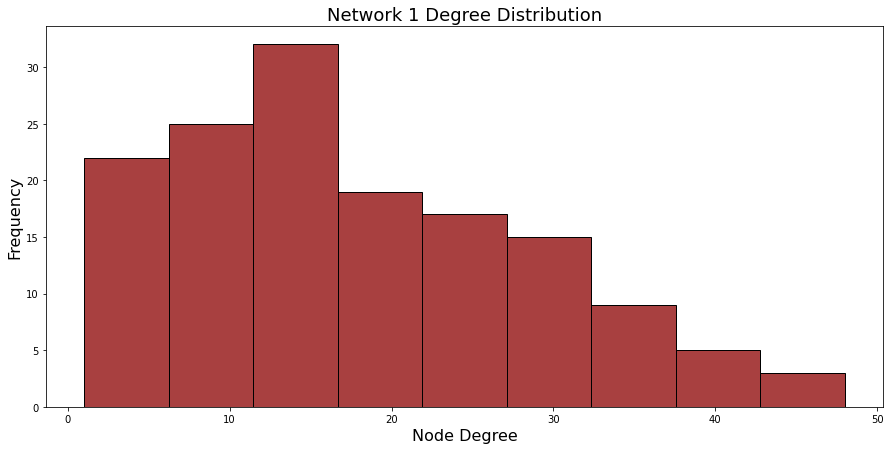

In [18]:
# compute node degree statistics and plot distribution
def degree_stats(net: nx.Graph, num: int) -> None:
    deg = pd.Series(dict(nx.degree(net)))
    print(f'Degree range: [{deg.min()}, {deg.max()}]')
    print(f'Mean degree: {deg.mean():.2f}')
    print(f'Median degree: {deg.median():.2f}')

    plt.figure(figsize=(15, 7))
    sns.histplot(data=deg, color='darkred' if num == 1 else 'teal')
    plt.title(f'Network {num} Degree Distribution', fontsize=18)
    plt.xlabel('Node Degree', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.show()


degree_stats(net1, 1)

Degree range: [1, 54]
Mean degree: 20.15
Median degree: 20.00


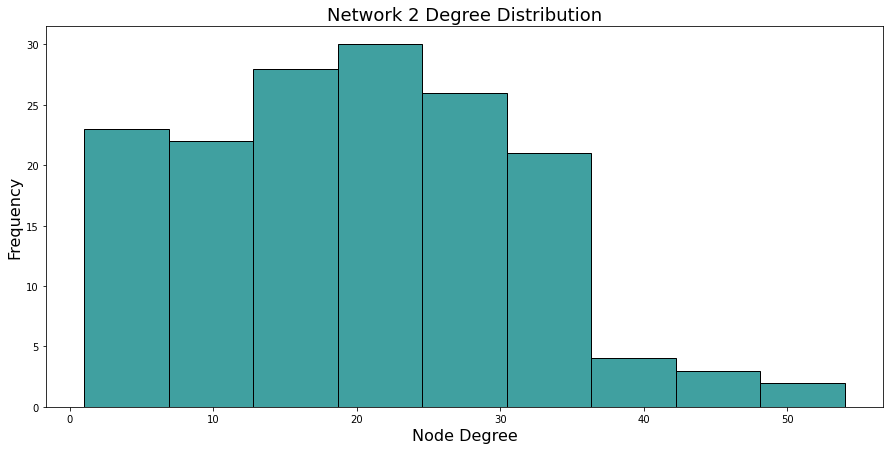

In [19]:
degree_stats(net2, 2)

It appears that mean/median node degrees for Network 2 are only slightly higher than those for Network 1. Network 1's distribution is more gradually tapered compared to Network 2, the latter having a steeper drop in frequency upon approaching a node degree of 40.

### Degree Centrality

**Degree centrality** can be computed by dividing the node degree scores by the maximum possible degree in the network, i.e., *n-1*, where *n* is the number of nodes in the network. It is appropriate when the number of connections in the network is important.

In [20]:
# compute degree centrality for every node and return as DataFrame
def degree_centrality(net: nx.Graph) -> pd.DataFrame:
    deg_cen = dict(nx.degree_centrality(net))
    return pd.DataFrame.from_dict(deg_cen, orient='index', columns=['degree_centrality'])


# Network 1
net1_df = degree_centrality(net1)
net1_df.sort_values(by='degree_centrality', ascending=False)

,degree_centrality
John Lithgow,0.329
Julianne Moore,0.322
Liam Neeson,0.322
Edward Norton,0.288
Matt Damon,0.281
...,...
David Niven,0.021
Ray Milland,0.021
Juliane Köhler,0.007
Birgit Minichmayr,0.007


In [21]:
# Network 2
net2_df = degree_centrality(net2)
net2_df.sort_values(by='degree_centrality', ascending=False)

,degree_centrality
Susan Sarandon,0.342
Bruce Willis,0.335
Woody Harrelson,0.304
Robert De Niro,0.285
Toby Jones,0.278
...,...
Peter Cushing,0.013
Sidney Poitier,0.013
Lola Dueñas,0.013
Julia Jentsch,0.006


John Lithgow (0.329) and Susan Sarandon (0.342) have the maximum degree centrality scores for Network 1 and Network 2 respectively, i.e., they have worked with the most number of actors in their respective networks.

### Betweenness Centrality

Degree centrality does not capture the idea of brokerage. **Betweenness centrality** determines the relative importance of a node by measuring the amount of traffic flowing through that node to other nodes in the network. This is done by measuring the fraction of paths connecting all pairs of nodes and containing the node of interest. Strategic linkages, “brokers” or “bridging nodes” in a network are identified, and this measure is appropriate when control over information transmission is important.

In [22]:
# compute betweenness centrality (optionally weighted) and return single column DataFrame
def betweenness(df: pd.DataFrame, net: nx.Graph, weight: str = None) -> pd.DataFrame:
    bet = nx.betweenness_centrality(net, weight=weight)
    title = 'betweenness' if not weight else 'weighted_betweenness'
    df[title] = pd.Series(bet)
    return pd.DataFrame(df[title].sort_values(ascending=False))


# Network 1
betweenness(net1_df, net1)

,betweenness
Liam Neeson,4.186e-02
John Lithgow,3.793e-02
Matt Damon,3.618e-02
Robert Duvall,2.979e-02
Natalie Portman,2.744e-02
...,...
Olivia Colman,2.814e-05
Leonor Watling,2.641e-05
Juliane Köhler,0.000e+00
Birgit Minichmayr,0.000e+00


In [23]:
# Network 2
betweenness(net2_df, net2)

,betweenness
Bruce Willis,0.049
Susan Sarandon,0.042
Robert De Niro,0.033
Willem Dafoe,0.028
Toby Jones,0.026
...,...
Peter Cushing,0.000
Sidney Poitier,0.000
Chuck Norris,0.000
Julia Jentsch,0.000


We can also compute the **weighted betweenness centrality** where shortest paths are computed considering edge weights.

In [24]:
# Network 1
betweenness(net1_df, net1, 'weight')

,weighted_betweenness
Matt Damon,4.561e-02
John Lithgow,3.796e-02
Liam Neeson,3.637e-02
Natalie Portman,3.295e-02
Robert Duvall,3.159e-02
...,...
Olivia Colman,1.969e-05
Bonnie Wright,4.972e-06
Juliane Köhler,0.000e+00
Birgit Minichmayr,0.000e+00


In [25]:
# Network 2
betweenness(net2_df, net2, 'weight')

,weighted_betweenness
Bruce Willis,0.047
Susan Sarandon,0.040
Willem Dafoe,0.037
Ian Hart,0.033
Gabriel Byrne,0.031
...,...
Lola Dueñas,0.000
Sidney Poitier,0.000
Rupert Grint,0.000
Julia Jentsch,0.000


For Network 1, Liam Neeson (0.042, unweighted) and Matt Damon (0.046, weighted) are the most important "bridging nodes". For Network 2, Bruce Willis takes the top spot with (0.049, unweighted) and (0.047, weighted) betweenness scores.

### Closeness Centrality

**Closeness centrality** determines how "close" a node is to other nodes in a network by measuring the sum of the shortest distances (geodesic paths) between that node and all other nodes in the network. This reflects on a node’s ability to access information through the "grapevine" of network members.



In [26]:
# compute closeness centrality and return single column DataFrame
def closeness(df: pd.DataFrame, net: nx.Graph) -> pd.DataFrame:
    close = nx.closeness_centrality(net)
    df['closeness'] = pd.Series(close)
    return pd.DataFrame(df['closeness'].sort_values(ascending=False))


# Network 1
closeness(net1_df, net1)

,closeness
John Lithgow,0.584
Liam Neeson,0.580
Julianne Moore,0.580
Matt Damon,0.566
Meryl Streep,0.564
...,...
Ziyi Zhang,0.360
David Niven,0.348
Matthew Perry,0.338
Juliane Köhler,0.007


In [27]:
# Network 2
closeness(net2_df, net2)

,closeness
Bruce Willis,0.592
Susan Sarandon,0.590
Woody Harrelson,0.579
Robert De Niro,0.568
Willem Dafoe,0.566
...,...
August Diehl,0.368
Peter Cushing,0.358
Rex Harrison,0.357
Taraneh Alidoosti,0.298


John Lithgow (0.584) and Bruce Willis (0.592) are "closest" to the other actor nodes in their respective networks 1 and 2.

### Eigenvector Centrality

**Eigenvector centrality** is a more sophisticated version of degree centrality where the centrality of a node not only depends on the number of links incident on the node but also the quality of those links. This quality factor is determined by the eigenvectors of the adjacency matrix of the network. **Normalisation** can often be useful to allow for comparisons across different networks, and it is calculated relative to the maximum value in the current network.

In [28]:
# compute eigenvector centrality (including normalised) (optionally weighted) and return double column DataFrame
def eigenvector(df: pd.DataFrame, net: nx.Graph, weight: str = None) -> pd.DataFrame:
    eig = nx.eigenvector_centrality(net, weight=weight)
    values = pd.Series(eig)
    title = 'eigenvector' if not weight else 'weighted_eigenvector'

    df[title] = values
    df[f'norm_{title}'] = values/max(values)
    return df[[title, f'norm_{title}']].sort_values(by=title, ascending=False)


# Network 1
eigenvector(net1_df, net1)

,eigenvector,norm_eigenvector
Julianne Moore,1.996e-01,1.000e+00
John Lithgow,1.912e-01,9.575e-01
Edward Norton,1.831e-01,9.173e-01
Liam Neeson,1.799e-01,9.012e-01
Meryl Streep,1.591e-01,7.967e-01
...,...,...
Ziyi Zhang,5.937e-03,2.974e-02
David Niven,3.580e-03,1.793e-02
Matthew Perry,3.476e-03,1.741e-02
Juliane Köhler,5.189e-14,2.599e-13


In [29]:
# Network 2
eigenvector(net2_df, net2)

,eigenvector,norm_eigenvector
Susan Sarandon,1.771e-01,1.000
Bruce Willis,1.757e-01,0.992
Woody Harrelson,1.662e-01,0.939
Robert De Niro,1.518e-01,0.857
Julia Roberts,1.507e-01,0.851
...,...,...
August Diehl,6.139e-03,0.035
Peter Cushing,5.749e-03,0.032
Rex Harrison,4.998e-03,0.028
Taraneh Alidoosti,7.792e-04,0.004


In terms of "importance of neighbours", Julianne Moore (0.1996) and Susan Sarandon (0.1771) are the actors with the maximum eigenvector centrality for Networks 1 and 2 respectively.

### Summary of Network Characteristics

Based on all the measures above, Network 1 and Network 2 can be compared as follows:
- **Size**: both networks are comparable in size; Network 1 with (147 nodes, 1322 edges) and Network 2 with (159 nodes, 1602 edges).
- **Edge weight distribution**: about 90% of edges on both networks have small weights (1-2).
- **Top co-starring relationships**: for both networks, the maximum number of movies in which any two actors had co-starred was 10.
- **Density**: similar scores ~0.12 (sparse).
- **Connectedness**: Network 1 has 2 components, whereas Network 2 has a single large one.
- **Diameter**: comparable; 4 for Network 1's larger component, 5 for entire Network 2.
- **Paths**: both networks have nearly identical average shortest path lengths ~2.1 (considering Network 1's larger component only).
- **Clustering coefficient**: both networks have comparable average clustering coefficient scores ~0.3. 
- **Degree distribution**: both networks have similar degree ranges ([1, 48] and [1, 54]) as well as comparable mean degree scores (17.99 and 20.15).
- **Centrality measures**: the correlation between centrality measures is summarised by the heatmaps below. 

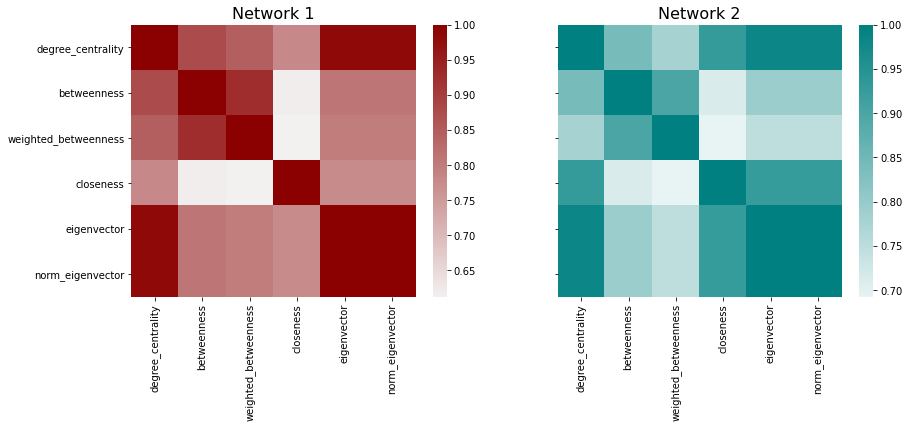

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                               figsize=(14, 5), sharex=True, sharey=True)
sns.heatmap(data=net1_df.corr(), cmap=sns.light_palette(
    'darkred', as_cmap=True), ax=ax1)
ax1.set_title('Network 1', fontsize=16)

sns.heatmap(data=net2_df.corr(), cmap=sns.light_palette(
    'teal', as_cmap=True), ax=ax2)
ax2.set_title('Network 2', fontsize=16)
plt.show()

It is interesting to note that for both networks, all centrality measures are highly correlated with one another. Even the least correlated pairs (betweenness and closeness) have a moderate positive correlation score of almost 0.65.

## Ego-centric Analysis

As previously pointed out, the concept of node "importance" is highly subjective. For ego-centric analysis, let's further explore the nodes with the highest betweenness centrality scores for both networks. For Network 1, **Liam Neeson** tops the list of actors with an unweighted score of 0.042. In case of Network 2, **Bruce Willis** has a similar best score of 0.049. The nodes with high betweenness centrality scores maintain the connectivity of both networks, and removing them would break the networks into multiple components. Liam Neeson and Bruce Willis are clearly important actor nodes for the two networks, since they consistently appear in the top 3 for the other centrality measures described above.

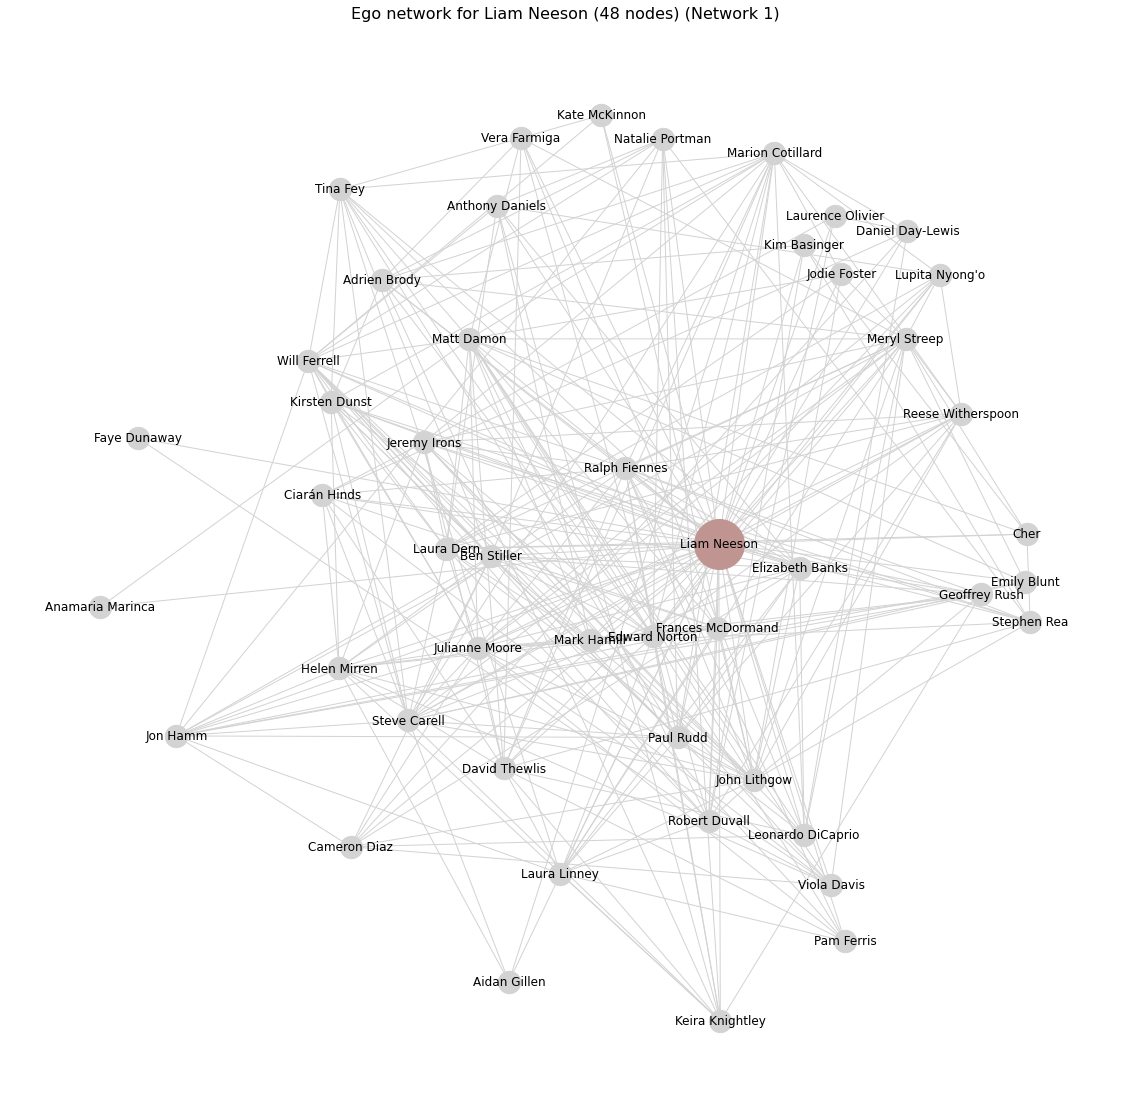

Network 1 ego: Liam Neeson
Number of nodes: 48
Number of edges: 297
Density: 0.263
Connected: True
Diameter: 2
Average shortest path length: 1.737
Average clustering coefficient: 0.534
Average degree: 12.375


In [31]:
# display ego network and some of its basic structural characteristics
def ego_analysis(net: nx.Graph, num: int, ego: str) -> None:
    # create ego network and set layout (param k increases distance between nodes)
    eg = nx.ego_graph(net, ego)
    pos = nx.spring_layout(net, k=2.25)
    
    plt.figure(figsize=(20, 20))
    plt.margins(0.1, 0.1)
    title = f'Ego network for {ego} ({eg.number_of_nodes()} nodes) (Network {num})'
    plt.title(title, fontsize=16)
    
    # draw the full network
    nx.draw_networkx(eg, pos, with_labels=True, font_size=12,
                     node_size=500, node_color='lightgrey', edge_color='lightgrey')
    
    # draw the ego in a different colour with larger node size
    nx.draw_networkx_nodes(eg, pos, nodelist=[ego], node_size=2500, 
                           node_color='#c09591' if num == 1 else '#89d5d2')
    plt.axis("off")
    plt.show()
    
    # compute network characteristics
    print(f'Network {num} ego: {ego}')
    print(f'Number of nodes: {eg.number_of_nodes()}')
    print(f'Number of edges: {eg.number_of_edges()}')
    print(f'Density: {nx.density(eg):.3f}')
    print(f'Connected: {nx.is_connected(eg)}')
    print(f'Diameter: {nx.diameter(eg)}')
    print(f'Average shortest path length: {nx.average_shortest_path_length(eg):.3f}')
    print(f'Average clustering coefficient: {nx.average_clustering(eg):.3f}')
    print(f'Average degree: {pd.Series(dict(nx.degree(eg))).mean():.3f}')
    
    
ego_analysis(net1, 1, 'Liam Neeson')

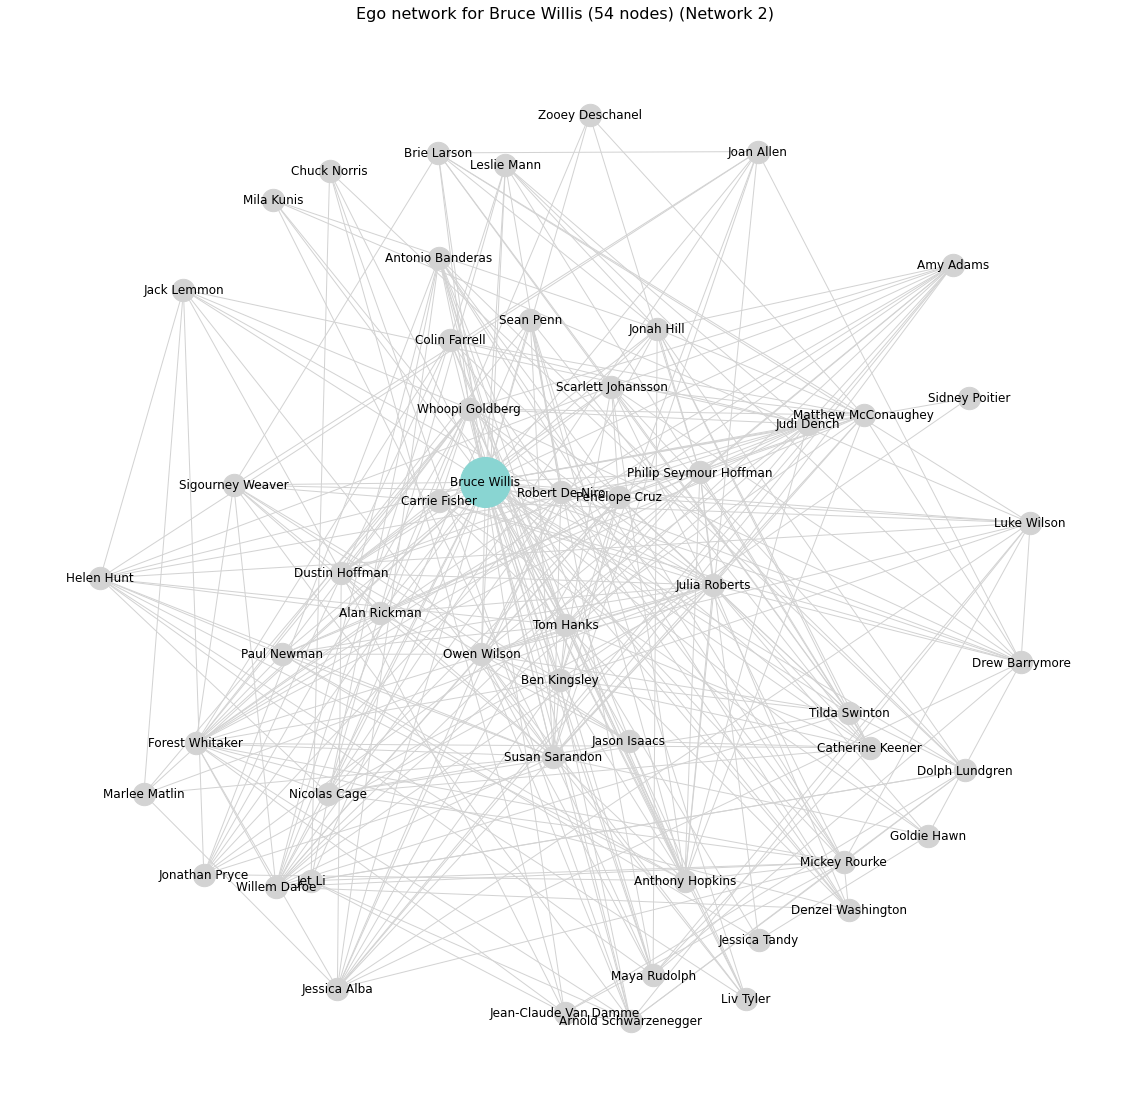

Network 2 ego: Bruce Willis
Number of nodes: 54
Number of edges: 353
Density: 0.247
Connected: True
Diameter: 2
Average shortest path length: 1.753
Average clustering coefficient: 0.486
Average degree: 13.074


In [32]:
ego_analysis(net2, 2, 'Bruce Willis')

Each ego network above was visualised using a spring layout. A variety of network characteristics were also computed (size, density, connectedness, diameter, average shortest path length, clustering coefficient and degree), which have been described in detail for the full networks earlier.

Both networks have similar density ~ 0.25, comprise a single connected component, and have an identical diameter of 2. Average shortest path lengths are also comparable (~1.7). There are only minor differences between the ego networks in terms of the other characteristics (number of nodes, edges, average clustering coefficient and degree).

## Network Visualisation

Finally, we can export both networks as GEXF files and produce visualisations using Gephi (saved as `net1.png` and `net2.png`). The node colour, node size and label size have all been scaled by the betweenness centrality scores. The force-directed layout algorithm used is Fruchterman Reingold. 

In [33]:
nx.write_gexf(net1, 'net1.gexf', prettyprint=True)

![](net1.png)

In [34]:
nx.write_gexf(net2, 'net2.gexf', prettyprint=True)

![](net2.png)